# Data Augmentation For Object Detection

This notebook serves as general manual to using this codebase. We cover all the major augmentations, as well as ways to combine them. 

In [2]:
from data_aug.data_aug import *
from data_aug.bbox_util import *
import numpy as np 
import cv2 
import matplotlib.pyplot as plt 
import pickle as pkl
%matplotlib inline

## Storage Format 

First things first, we define how the storage formats required for images to work. 
1. **The Image**: A OpenCV numpy array, of shape *(H x W x C)*. 
2. **Annotations**: A numpy array of shape *N x 5* where *N* is the number of objects, one represented by each row. 5 columns represent the top-left x-coordinate, top-left y-coordinate, bottom-right x-coordinate, bottom-right y-coordinate, and the class of the object. 

Here is an image to aid your imagination. 

![Annotation Format](ann_form.jpg)

Whatever format your annotations are present in make sure, you convert them to this format.

For demonstration purposes, we will be using the image above to show the transformations. The image as well as it's annotation has been provided. The annotation is a numpy array in a pickled format. 

In [3]:
img = cv2.imread("messi.jpg")[:,:,::-1]   #opencv loads images in bgr. the [:,:,::-1] does bgr -> rgb
bboxes = pkl.load(open("messi_ann.pkl", "rb"))

#inspect the bounding boxes
print(bboxes)

[[ 53.         68.0000175 405.        478.9998225   0.       ]
 [202.         20.99992   496.        486.99978     0.       ]
 [589.         77.0001275 737.        335.9999825   0.       ]
 [723.        327.000125  793.        396.000295    1.       ]]


You can use the function `draw_rect` to plot the bounding boxes on an image. 

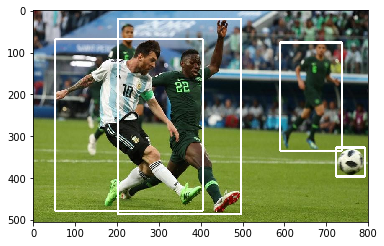

In [4]:
plotted_img = draw_rect(img, bboxes)
plt.imshow(plotted_img)
plt.show()

Now, we can get started with our image augmentations. The first one is **Horizontal Flipping**. The function takes one arguement, *p* which is the probability that the image will be flipped. 

In [5]:
try:
#     import numpy as np
    import xml.etree.cElementTree as ET  #解析xml的c语言版的模块
except ImportError:
    import xml.etree.ElementTree as ET

# get object annotation bndbox loc start 
def getAnnotBoxLoc(AnotPath):#AnotPath VOC标注文件路径
    tree = ET.ElementTree(file=AnotPath)  #打开文件，解析成一棵树型结构
    root = tree.getroot()#获取树型结构的根
    ObjectSet=root.findall('object')#找到文件中所有含有object关键字的地方，这些地方含有标注目标
    ObjBndBoxSet={} #以目标类别为关键字，目标框为值组成的字典结构
    for Object in ObjectSet:
        ObjName=Object.find('name').text
        BndBox=Object.find('bndbox')
        x1 = float(BndBox.find('xmin').text)#-1 #-1是因为程序是按0作为起始位置的
        y1 = float(BndBox.find('ymin').text)#-1
        x2 = float(BndBox.find('xmax').text)#-1
        y2 = float(BndBox.find('ymax').text)#-1
        BndBoxLoc=[x1,y1,x2,y2]
        if ObjBndBoxSet.__contains__(ObjName):
            ObjBndBoxSet[ObjName].append(BndBoxLoc)#如果字典结构中含有这个类别了，那么这个目标框要追加到其值的末尾
        else:
            ObjBndBoxSet[ObjName]=[BndBoxLoc]#如果字典结构中没有这个类别，那么这个目标框就直接赋值给其值吧
    if len(ObjBndBoxSet.keys()) == 1:
        return np.array(ObjBndBoxSet[ObjName])
    else:
        return ObjBndBoxSet

data = getAnnotBoxLoc("/home/hzh/huawei/banner_data/train/xml/train_0000.xml")
print(type(data), data)

<class 'numpy.ndarray'> [[  5. 272. 390. 387.]
 [390. 265. 465. 287.]]


In [17]:
data_path = '/home/hzh/huawei/banner_data/new_data/train/image'
xml_path = '/home/hzh/huawei/banner_data/new_data/train/xml'
aug_data_path = '/home/hzh/huawei/banner_data/new_data/hf_train/image'
aug_xml_path = '/home/hzh/huawei/banner_data/new_data/hf_train/xml'
train_image_list = os.listdir(data_path)
print(len(train_image_list))

for image_name in train_image_list:
    img = cv2.imread(os.path.join(data_path, image_name))
    bboxes = getAnnotBoxLoc(os.path.join(xml_path, image_name.split('.')[0]+'.xml'))
    img_, bboxes_ = RandomHorizontalFlip(1)(img.copy(), bboxes.copy())
    bboxes_.astype(np.int64)
#     保存图片
    cv2.imwrite(os.path.join(aug_data_path, image_name.split('.')[0]+'_hf.jpg'), img_)
#     保存标注
    tree = ET.ElementTree(file=os.path.join(xml_path, image_name.split('.')[0]+'.xml'))
    root = tree.getroot()
    
    name = root.find('filename')
    name.text = image_name.split('.')[0]+'_hf.jpg'
    
    objectSet = root.findall('object')
    for i,obj in enumerate(objectSet):
        bndBox = obj.find('bndbox')
        bndBox.find('xmin').text = str(int(bboxes_[i][0]))
        bndBox.find('ymin').text = str(int(bboxes_[i][1]))
        bndBox.find('xmax').text = str(int(bboxes_[i][2]))
        bndBox.find('ymax').text = str(int(bboxes_[i][3]))
    tree.write(os.path.join(aug_xml_path, image_name.split('.')[0]+'_hf.xml'))

369


In [60]:
# rename
data_path = '/home/hzh/huawei/banner_data/train/image'
xml_path = '/home/hzh/huawei/banner_data/train/xml'
new_data_path = '/home/hzh/huawei/banner_data/new_train/image'
new_xml_path = '/home/hzh/huawei/banner_data/new_train/xml'
train_data_list = os.listdir(data_path)
print(len(test_data_list))

for i,image_name in enumerate(train_data_list):
    # save image
    img = cv2.imread(os.path.join(data_path, image_name))
    new_name = 'train_' + str(i).zfill(4) + '.jpg'
    cv2.imwrite(os.path.join(new_data_path, new_name), img)
    
    # save xml
    tree = ET.ElementTree(file=os.path.join(xml_path, image_name.split('.')[0]+'.xml'))
    root = tree.getroot()
    name = root.find('filename')
    name.text = new_name
    tree.write(os.path.join(new_xml_path, new_name.split('.')[0]+'.xml'))

240


**Rotation**. Rotates the image. 

If the first argument is a int, then the rotating angle, in degrees, is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

In [11]:
import random
data_path = '/home/hzh/huawei/banner_data/new_data/test/'
# xml_path = '/home/hzh/huawei/banner_data/test/xml'
aug_path = '/home/hzh/huawei/banner_data/new_data/aug_test/'
image_list = os.listdir(data_path)
print(len(image_list))

i = 0

for image_name in image_list:
    i+=1
#     x = random.randint(0,9)
    img = cv2.imread(os.path.join(data_path, image_name))
#     bboxes = getAnnotBoxLoc(os.path.join(xml_path, image_name.split('.')[0]+'.xml'))
    bboxes = np.array([[10,20,10,30], [5,32,7,44]], dtype=np.float64)
    print(bboxes)
#     break
    if i % 3 == 0:
        img_, bboxes_ = Rotate(356)(img.copy(), bboxes.copy())
    elif i % 3 == 1:
        img_, bboxes_ = Rotate(5)(img.copy(), bboxes.copy())
    else:
        img_, bboxes_ = Rotate(3)(img.copy(), bboxes.copy())
        
#     plotted_img = draw_rect(img_, bboxes_)
#     plt.imshow(plotted_img)
#     plt.show()

    bboxes_.astype(np.int64)
#     保存图片
    cv2.imwrite(os.path.join(aug_path, image_name.split('.')[0]+'_rt.jpg'), img_)
    #     保存标注
    #     tree = ET.ElementTree(file=os.path.join(xml_path, image_name.split('.')[0]+'.xml'))
    #     root = tree.getroot()

    #     name = root.find('filename')
    #     name.text = image_name.split('.')[0]+'_hf.jpg'

    #     objectSet = root.findall('object')
    #     for i,obj in enumerate(objectSet):
    #         bndBox = obj.find('bndbox')
    #         bndBox.find('xmin').text = str(int(bboxes_[i][0]))
    #         bndBox.find('ymin').text = str(int(bboxes_[i][1]))
    #         bndBox.find('xmax').text = str(int(bboxes_[i][2]))
    #         bndBox.find('ymax').text = str(int(bboxes_[i][3]))
    #     tree.write(os.path.join(aug_path, image_name.split('.')[0]+'_rt.xml'))
    #     break

73
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
356
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
5
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3
[[10. 20. 10. 30.]
 [ 5. 32.  7. 44.]]
3

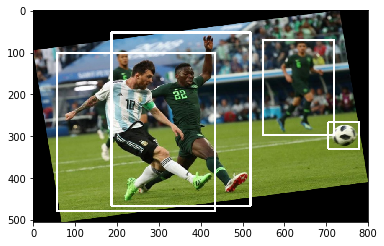

In [18]:
img_, bboxes_ = RandomRotate(20)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Shearing**. Sheares the image horizontally

If the first argument is a float, then the shearing factor is sampled from *(- arg, arg)*. Otherwise, you can specify a tuple for this range.

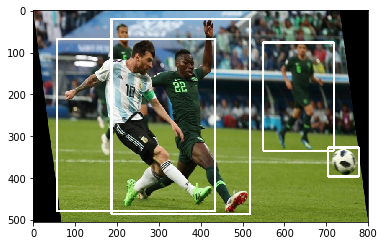

In [19]:
img_, bboxes_ = RandomShear(0.2)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

**Resizing**.  Resizes the image to square dimensions while keeping the aspect ratio constant.

The argument to this augmentation is the side of the square.

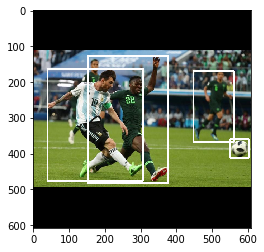

In [20]:
img_, bboxes_ = Resize(608)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

HSV transforms are supported as well. 

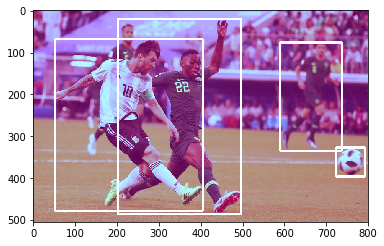

In [21]:
img_, bboxes_ = RandomHSV(100, 100, 100)(img.copy(), bboxes.copy())
plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

You can combine multiple transforms together by using the Sequence class as follows. 

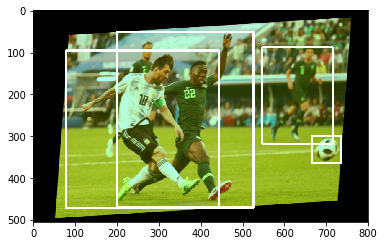

In [22]:
seq = Sequence([RandomHSV(40, 40, 30),RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
img_, bboxes_ = seq(img.copy(), bboxes.copy())

plotted_img = draw_rect(img_, bboxes_)
plt.imshow(plotted_img)
plt.show()

A list of all possible transforms can be found in the `docs` folder.




